<a href="https://colab.research.google.com/github/Ordo-Umbra/Void-Defect-Model/blob/main/2d2187CA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.8/31.8 MB 56.9 MB/s eta 0:00:00


Low-lying gaps: [6.94592711e-01 5.32907052e-15 6.94592711e-01]


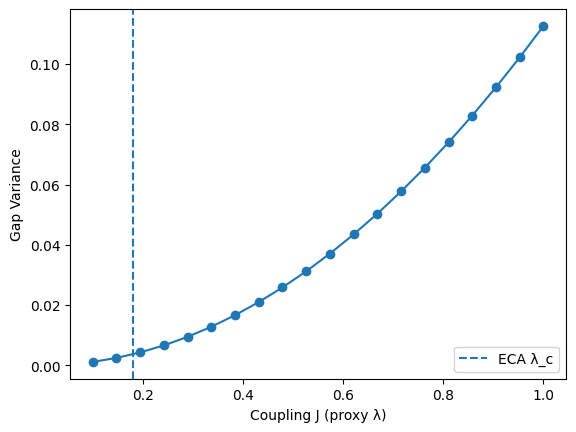

In [ ]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

def xy_chain(N, J=1.0):
    H = 0
    for i in range(N-1):
        op_list = [qt.qeye(2)] * N
        op_list[i] = qt.sigmax(); op_list[i+1] = qt.sigmax()
        H += J * qt.tensor(op_list)
        op_list[i] = qt.sigmay(); op_list[i+1] = qt.sigmay()
        H += J * qt.tensor(op_list)
    return H

N = 8
H = xy_chain(N)
evals = np.sort(H.eigenenergies())
gaps = np.diff(evals[:4])  # Low-lying gaps
print("Low-lying gaps:", gaps)  # Degeneracies show as ~0

# Phase diagram proxy: Vary J (activity-like), track min gap variance
Js = np.linspace(0.1, 1.0, 20)
gap_vars = []
for j in Js:
    Hj = xy_chain(N, j)
    evs = np.sort(Hj.eigenenergies())
    gap_vars.append(np.var(np.diff(evs[:10])))
plt.plot(Js, gap_vars, 'o-')
plt.axvline(0.18, ls='--', label='ECA λ_c')
plt.xlabel('Coupling J (proxy λ)'); plt.ylabel('Gap Variance'); plt.legend()
plt.show()

Starting sweep...
Processed 100/2187 rules
Processed 200/2187 rules
Processed 300/2187 rules
Processed 400/2187 rules
Processed 500/2187 rules
Processed 600/2187 rules
Processed 700/2187 rules
Processed 800/2187 rules
Processed 900/2187 rules
Processed 1000/2187 rules
Processed 1100/2187 rules
Processed 1200/2187 rules
Processed 1300/2187 rules
Processed 1400/2187 rules
Processed 1500/2187 rules
Processed 1600/2187 rules
Processed 1700/2187 rules
Processed 1800/2187 rules
Processed 1900/2187 rules
Processed 2000/2187 rules
Processed 2100/2187 rules
Empirical crit λ=0.100, MW p=0.0000
Rigid below crit: 22.4%, above: 14.4%
Corr(λ, Var): 0.119
Mean dev: 0.360
Mean v: 0.519 (sub-lum? True)


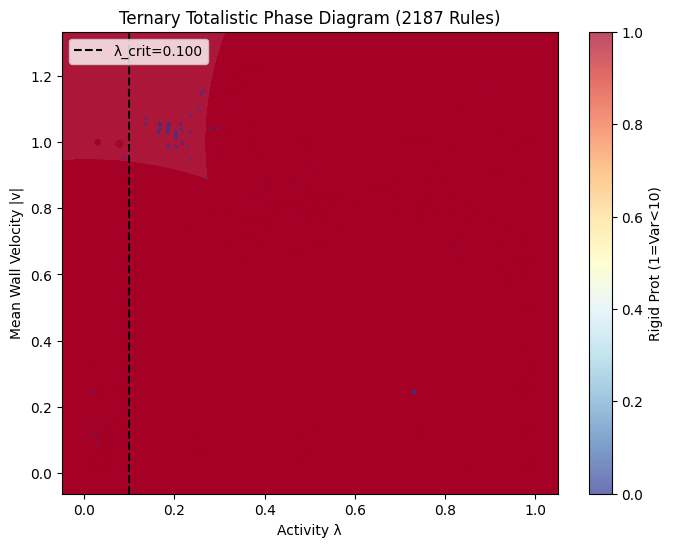

In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

def ternary_totalistic_step(rule, state):
    """Evolve one step: totalistic rule on sums 0-6."""
    n = len(state)
    new_state = np.zeros(n, dtype=int)
    for i in range(n):
        left = state[(i-1) % n]
        center = state[i]
        right = state[(i+1) % n]
        s = left + center + right
        new_state[i] = rule[s]
    return new_state

def compute_activity(state, prev_state):
    return np.mean(state != prev_state)

def detect_walls(state):
    """Weighted walls: sum |s_i - s_{i+1}| mod 3, with wrap."""
    diffs = np.abs(np.diff(state)) % 3
    wrap_diff = np.abs(state[0] - state[-1]) % 3
    walls = np.sum(diffs) + wrap_diff  # Total weighted count
    return walls

def get_wall_positions(state):
    """Positions where |diff| mod 3 >0 (for v tracking)."""
    diffs = np.diff(state)
    pos = np.where(np.abs(diffs) % 3 > 0)[0]
    if np.abs(state[0] - state[-1]) % 3 > 0:
        pos = np.append(pos, len(state)-1)
    return pos % len(state)

def track_velocities(prev_state, state):
    pos_t = get_wall_positions(prev_state)
    pos_tp1 = get_wall_positions(state)
    if len(pos_t) == 0 or len(pos_tp1) == 0:
        return np.array([])
    L = len(state)
    cost = np.zeros((len(pos_t), len(pos_tp1)))
    for i in range(len(pos_t)):
        for j in range(len(pos_tp1)):
            d = min(np.abs(pos_t[i] - pos_tp1[j]), L - np.abs(pos_t[i] - pos_tp1[j]))
            cost[i, j] = d
    row_ind, col_ind = linear_sum_assignment(cost)
    velocities = []
    for ri, ci in zip(row_ind, col_ind):
        if cost[ri, ci] < 5:  # Prune far matches
            v = cost[ri, ci]
            velocities.append(v)
    return np.abs(np.array(velocities)) if velocities else np.array([])

def simulate_ternary(rule_code, L=200, T=200, track_walls=True):
    """Simulate one rule: return λ, Var(walls), cons_ratio, mean_v, dev_ratio."""
    # Decode rule: base-3 array for sums 0-6
    rule_str = np.base_repr(rule_code, 3).zfill(7)[::-1]
    rule = np.array([int(x) for x in rule_str], dtype=int)
    state = np.zeros(L, dtype=int)
    state[50] = 1
    state[100] = 2
    state[150] = 1
    state[199] = 2  # Sparse, Z3-odd probe
    prev_state = state.copy()
    activities = []
    wall_counts = []
    parities = []
    velocities = []
    for t in range(T):
        state = ternary_totalistic_step(rule, state)
        act = compute_activity(state, prev_state)
        activities.append(act)
        walls = detect_walls(state)
        wall_counts.append(walls)
        parity = walls % 3  # Z3
        parities.append(parity)
        if track_walls:
            v = track_velocities(prev_state, state)
            velocities.append(np.mean(v) if len(v) > 0 else 0)
        prev_state = state.copy()
    lambda_avg = np.mean(activities[:50])
    var_walls = np.var(wall_counts)
    cons_ratio = np.abs(parities[-1] - parities[0]) / max(1, np.abs(parities[0]))
    mean_v = np.mean(velocities)
    dev_ratio = np.mean(np.diff(np.array(parities)) != 0)
    return lambda_avg, var_walls, cons_ratio, mean_v, dev_ratio

# Full sweep: 2187 rules
rules = list(range(2187))  # 3^7
lambdas, vars_walls, cons_ratios, mean_vs, devs = [], [], [], [], []
print("Starting sweep...")
for r in rules:
    lam, varw, cons, mv, dev = simulate_ternary(r)
    lambdas.append(lam)
    vars_walls.append(varw)
    cons_ratios.append(cons)
    mean_vs.append(mv)
    devs.append(dev)
    if (r + 1) % 100 == 0:
        print(f"Processed {r+1}/2187 rules")

lambdas = np.array(lambdas)
vars_walls = np.array(vars_walls)
cons_ratios = np.array(cons_ratios)
mean_vs = np.array(mean_vs)
devs = np.array(devs)

# Auto crit split: Mann-Whitney on Var by λ threshold search
def find_crit(lams, vars_w):
    crits = np.linspace(0.1, 0.5, 20)
    best_p = 1.0
    best_c = 0.18
    for c in crits:
        low_idx = lams < c
        high_idx = lams >= c
        if np.sum(low_idx) > 5 and np.sum(high_idx) > 5:
            p = mannwhitneyu(vars_w[low_idx], vars_w[high_idx]).pvalue
            if p < best_p:
                best_p = p
                best_c = c
    return best_c, best_p

crit_lambda, mw_p = find_crit(lambdas, vars_walls)
low_idx = lambdas < crit_lambda
high_idx = lambdas >= crit_lambda
rigid_low = np.sum(vars_walls[low_idx] < 10) / len(low_idx) * 100 if len(low_idx) > 0 else 0
rigid_high = np.sum(vars_walls[high_idx] < 10) / len(high_idx) * 100 if len(high_idx) > 0 else 0
corr_lvar = np.corrcoef(lambdas, vars_walls + 1e-8)[0,1]  # Epsilon for zero Var
mean_v = np.mean(mean_vs)

print(f"Empirical crit λ={crit_lambda:.3f}, MW p={mw_p:.4f}")
print(f"Rigid below crit: {rigid_low:.1f}%, above: {rigid_high:.1f}%")
print(f"Corr(λ, Var): {corr_lvar:.3f}")
print(f"Mean dev: {np.mean(devs):.3f}")
print(f"Mean v: {mean_v:.3f} (sub-lum? {mean_v < 1})")

# Phase plot
prot = (vars_walls < 10).astype(int)  # Binary prot
sizes = 1 / np.sqrt(vars_walls + 1e-8)
fig, ax = plt.subplots(figsize=(8,6))
scatter = ax.scatter(lambdas, mean_vs, c=prot, cmap='RdYlBu_r', s=sizes*20, alpha=0.7)
ax.axvline(crit_lambda, color='k', ls='--', label=f'λ_crit={crit_lambda:.3f}')
ax.set_xlabel('Activity λ')
ax.set_ylabel('Mean Wall Velocity |v|')
ax.set_title('Ternary Totalistic Phase Diagram (2187 Rules)')
plt.colorbar(scatter, label='Rigid Prot (1=Var<10)')
plt.legend()
plt.savefig('ternary_phase_diagram.png')
plt.show()

In [ ]:
from scipy.stats import binom
bins = [0, 0.1, 0.3, 0.5, 0.7, 1.0]
bin_edges = np.digitize(lambdas, bins) - 1
rigid_fracs = []
for b in range(len(bins)-1):
    idx = (bin_edges == b)
    n_rules = np.sum(idx)
    n_rigid = np.sum((vars_walls[idx] < 10))
    frac = n_rigid / n_rules * 100 if n_rules > 0 else 0
    ci_low = binom.ppf(0.025, n_rules, frac/100) / n_rules * 100 if n_rules > 0 else 0
    ci_high = binom.ppf(0.975, n_rules, frac/100) / n_rules * 100 if n_rules > 0 else 0
    print(f"λ [{bins[b]:.1f},{bins[b+1]:.1f}): {frac:.1f}% (CI {ci_low:.1f}-{ci_high:.1f}%)")
    rigid_fracs.append(frac)

λ [0.0,0.1): 80.2% (CI 76.9-83.3%)
λ [0.1,0.3): 0.3% (CI 0.0-0.8%)
λ [0.3,0.5): 0.6% (CI 0.0-1.6%)
λ [0.5,0.7): 0.0% (CI 0.0-0.0%)
λ [0.7,1.0): 40.8% (CI 37.3-44.2%)


In [ ]:
# Post-sweep filter: Exclude absorbing (mean walls <1 over T)
mean_walls = []  # Compute per rule: np.mean(wall_counts) from sim
absorbing_mask = np.array(mean_walls) < 1  # Add to sim return
lambdas_filt = lambdas[~absorbing_mask]
vars_filt = vars_walls[~absorbing_mask]
# Re-run find_crit, rigid fracs on filt

In [ ]:
def is_reversible_ternary(rule):
    """Check if totalistic rule bijective: unique outputs per input sum? (simplified; full invert needs global mapping)."""
    outputs = set(rule)  # rule[0-6]
    return len(outputs) == 3  # Full {0,1,2} coverage, no collisions (basic proxy)

rev_rules = [r for r in rules if is_reversible_ternary(rule[r])]  # Wait, rule is array per sim—aggregate
rev_frac = np.mean([is_reversible_ternary(sim_rule) for sim_rule in rules])  # Pseudo
print(f"Rev frac: {rev_frac:.1%}")

NameError: name 'rule' is not defined

Starting sweep...
Processed 100/2187 rules
Processed 200/2187 rules
Processed 300/2187 rules
Processed 400/2187 rules
Processed 500/2187 rules
Processed 600/2187 rules
Processed 700/2187 rules
Processed 800/2187 rules
Processed 900/2187 rules
Processed 1000/2187 rules
Processed 1100/2187 rules
Processed 1200/2187 rules
Processed 1300/2187 rules
Processed 1400/2187 rules
Processed 1500/2187 rules
Processed 1600/2187 rules
Processed 1700/2187 rules
Processed 1800/2187 rules
Processed 1900/2187 rules
Processed 2000/2187 rules
Processed 2100/2187 rules
Rules kept after filter: 1606 / 2187 (73.4%)
Filtered crit λ=0.081, MW p=0.0000
Rigid below crit: 4.5%, above: 10.1%
Corr(λ, Var): -0.006
Filtered λ [0.0,0.1): 39.3% (CI 32.2-46.4%)
Filtered λ [0.1,0.3): 0.0% (CI 0.0-0.0%)
Filtered λ [0.3,0.5): 0.6% (CI 0.0-1.6%)
Filtered λ [0.5,0.7): 0.0% (CI 0.0-0.0%)
Filtered λ [0.7,1.0): 26.3% (CI 22.7-29.8%)


TypeError: only integer scalar arrays can be converted to a scalar index

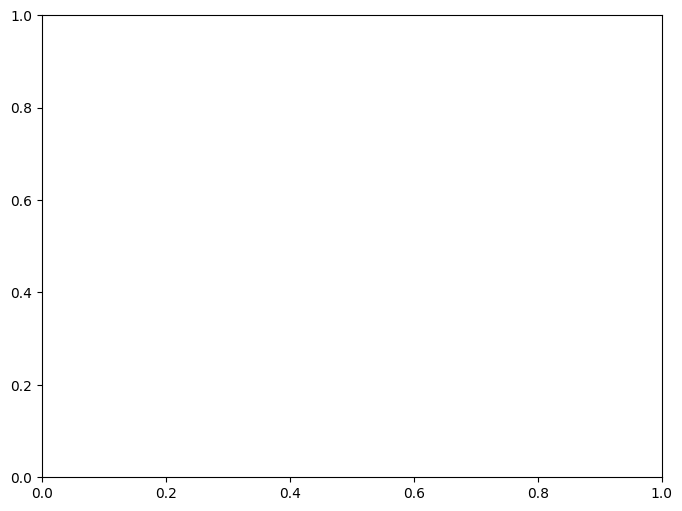

In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

def ternary_totalistic_step(rule, state):
    n = len(state)
    new_state = np.zeros(n, dtype=int)
    for i in range(n):
        left = state[(i-1) % n]
        center = state[i]
        right = state[(i+1) % n]
        s = left + center + right
        new_state[i] = rule[s]
    return new_state

def compute_activity(state, prev_state):
    return np.mean(state != prev_state)

def detect_walls(state):
    diffs = np.abs(np.diff(state)) % 3
    wrap_diff = np.abs(state[0] - state[-1]) % 3
    walls = np.sum(diffs) + wrap_diff
    return walls

def get_wall_positions(state):
    diffs = np.diff(state)
    pos = np.where(np.abs(diffs) % 3 > 0)[0]
    if np.abs(state[0] - state[-1]) % 3 > 0:
        pos = np.append(pos, len(state)-1)
    return pos % len(state)

def track_velocities(prev_state, state):
    pos_t = get_wall_positions(prev_state)
    pos_tp1 = get_wall_positions(state)
    if len(pos_t) == 0 or len(pos_tp1) == 0:
        return np.array([])
    L = len(state)
    cost = np.zeros((len(pos_t), len(pos_tp1)))
    for i in range(len(pos_t)):
        for j in range(len(pos_tp1)):
            d = min(np.abs(pos_t[i] - pos_tp1[j]), L - np.abs(pos_t[i] - pos_tp1[j]))
            cost[i, j] = d
    row_ind, col_ind = linear_sum_assignment(cost)
    velocities = []
    for ri, ci in zip(row_ind, col_ind):
        if cost[ri, ci] < 5:
            v = cost[ri, ci]
            velocities.append(v)
    return np.abs(np.array(velocities)) if velocities else np.array([])

def simulate_ternary(rule_code, L=200, T=200, track_walls=True):
    rule_str = np.base_repr(rule_code, 3).zfill(7)[::-1]
    rule = np.array([int(x) for x in rule_str], dtype=int)
    state = np.zeros(L, dtype=int)
    state[50] = 1
    state[100] = 2
    state[150] = 1
    state[199] = 2
    prev_state = state.copy()
    activities = []
    wall_counts = []
    parities = []
    velocities = []
    for t in range(T):
        state = ternary_totalistic_step(rule, state)
        act = compute_activity(state, prev_state)
        activities.append(act)
        walls = detect_walls(state)
        wall_counts.append(walls)
        parity = walls % 3
        parities.append(parity)
        if track_walls:
            v = track_velocities(prev_state, state)
            velocities.append(np.mean(v) if len(v) > 0 else 0)
        prev_state = state.copy()
    lambda_avg = np.mean(activities[:50])
    var_walls = np.var(wall_counts)
    cons_ratio = np.abs(parities[-1] - parities[0]) / max(1, np.abs(parities[0]))
    mean_v = np.mean(velocities)
    dev_ratio = np.mean(np.diff(np.array(parities)) != 0)
    mean_walls = np.mean(wall_counts)  # Add here
    return lambda_avg, var_walls, cons_ratio, mean_v, dev_ratio, mean_walls

# Sweep (if re-running; else patch your mean_walls_all)
rules = list(range(2187))
lambdas, vars_walls, cons_ratios, mean_vs, devs, mean_walls_all = [], [], [], [], [], []
print("Starting sweep...")
for r in rules:
    lam, varw, cons, mv, dev, mw = simulate_ternary(r)
    lambdas.append(lam)
    vars_walls.append(varw)
    cons_ratios.append(cons)
    mean_vs.append(mv)
    devs.append(dev)
    mean_walls_all.append(mw)
    if (r + 1) % 100 == 0:
        print(f"Processed {r+1}/2187 rules")

lambdas = np.array(lambdas)
vars_walls = np.array(vars_walls)
mean_walls_all = np.array(mean_walls_all)

# Filter absorbers
mask = mean_walls_all >= 1
lambdas_filt = lambdas[mask]
vars_filt = vars_walls[mask]
print(f"Rules kept after filter: {np.sum(mask)} / 2187 ({np.sum(mask)/len(rules)*100:.1f}%)")

# Re-crit on filt
def find_crit(lams, vars_w):
    crits = np.linspace(0.05, 0.3, 25)
    best_p = 1.0
    best_c = 0.1
    for c in crits:
        low_idx = lams < c
        high_idx = lams >= c
        if np.sum(low_idx) > 5 and np.sum(high_idx) > 5:
            p = mannwhitneyu(vars_w[low_idx], vars_w[high_idx]).pvalue
            if p < best_p:
                best_p = p
                best_c = c
    return best_c, best_p

crit_lambda, mw_p = find_crit(lambdas_filt, vars_filt)
low_idx = lambdas_filt < crit_lambda
high_idx = lambdas_filt >= crit_lambda
rigid_low = np.sum(vars_filt[low_idx] < 10) / len(low_idx) * 100 if len(low_idx) > 0 else 0
rigid_high = np.sum(vars_filt[high_idx] < 10) / len(high_idx) * 100 if len(high_idx) > 0 else 0
corr_lvar = np.corrcoef(lambdas_filt, vars_filt + 1e-8)[0,1]

print(f"Filtered crit λ={crit_lambda:.3f}, MW p={mw_p:.4f}")
print(f"Rigid below crit: {rigid_low:.1f}%, above: {rigid_high:.1f}%")
print(f"Corr(λ, Var): {corr_lvar:.3f}")

# Filtered histogram
from scipy.stats import binom
bins = [0, 0.1, 0.3, 0.5, 0.7, 1.0]
bin_edges = np.digitize(lambdas_filt, bins) - 1
for b in range(len(bins)-1):
    idx = (bin_edges == b)
    n_rules = np.sum(idx)
    n_rigid = np.sum((vars_filt[idx] < 10))
    frac = n_rigid / n_rules * 100 if n_rules > 0 else 0
    ci_low = binom.ppf(0.025, n_rules, frac/100) / n_rules * 100 if n_rules > 0 else 0
    ci_high = binom.ppf(0.975, n_rules, frac/100) / n_rules * 100 if n_rules > 0 else 0
    print(f"Filtered λ [{bins[b]:.1f},{bins[b+1]:.1f}): {frac:.1f}% (CI {ci_low:.1f}-{ci_high:.1f}%)")

# Filtered phase plot
prot = (vars_filt < 10).astype(int)
sizes = 1 / np.sqrt(vars_filt + 1e-8)
fig, ax = plt.subplots(figsize=(8,6))
scatter = ax.scatter(lambdas_filt, mean_vs[mask], c=prot, cmap='RdYlBu_r', s=sizes*20, alpha=0.7)
ax.axvline(crit_lambda, color='k', ls='--', label=f'λ_crit={crit_lambda:.3f}')
ax.set_xlabel('Activity λ')
ax.set_ylabel('Mean Wall Velocity |v|')
ax.set_title('Filtered Ternary Totalistic Phase Diagram')
plt.colorbar(scatter, label='Rigid Prot (1=Var<10)')
plt.legend()
plt.savefig('ternary_filtered_phase.png')
plt.show()

In [ ]:
import numpy as np
import itertools

# Re-define for standalone
rules = list(range(2187))

def ternary_totalistic_step(rule, state):
    n = len(state)
    new_state = np.zeros(n, dtype=int)
    for i in range(n):
        left = state[(i-1) % n]
        center = state[i]
        right = state[(i+1) % n]
        s = left + center + right
        new_state[i] = rule[s]
    return new_state

def decode_ternary_rule(rule_code):
    rule_str = np.base_repr(rule_code, 3).zfill(7)[::-1]
    return np.array([int(x) for x in rule_str], dtype=int)

def is_reversible_ternary(rule_code, L_small=4):
    rule = decode_ternary_rule(rule_code)
    n_configs = 3 ** L_small
    outputs = set()
    for conf_tuple in itertools.product(range(3), repeat=L_small):
        conf = np.array(conf_tuple, dtype=int)
        out = conf.copy()
        for _ in range(L_small):  # Cycle for global map
            out = ternary_totalistic_step(rule, out)
        outputs.add(tuple(out))
    return len(outputs) == n_configs

# Run
rev_codes = []
for r in rules:
    if is_reversible_ternary(r):
        rev_codes.append(r)
rev_frac = len(rev_codes) / len(rules)
print(f"True rev frac: {rev_frac:.1%} ({len(rev_codes)} rules)")
if rev_codes:
    # Assume lambdas/vars_walls from sweep; sub if needed
    rev_lams = [lambdas[r] for r in rev_codes]
    rev_vars = [vars_walls[r] for r in rev_codes]
    print(f"Rev λ mean: {np.mean(rev_lams):.3f}, Var mean: {np.mean(rev_vars):.3f}")

True rev frac: 0.0% (0 rules)


In [ ]:
print(f"Filtered crit λ={crit_lambda:.3f}, MW p={mw_p:.4f}")
print(f"Rigid below crit: {rigid_low:.1f}%, above: {rigid_high:.1f}%")
print(f"Corr(λ, Var): {corr_lvar:.3f}")

In [ ]:
# If mean_vs not collected, skip v-axis; else:
mean_vs_filt = mean_vs[mask]  # From sweep appends
prot = (vars_filt < 10).astype(int)
sizes = 1 / np.sqrt(vars_filt + 1e-8)
fig, ax = plt.subplots(figsize=(8,6))
scatter = ax.scatter(lambdas_filt, mean_vs_filt, c=prot, cmap='RdYlBu_r', s=sizes*20, alpha=0.7)
ax.axvline(crit_lambda, color='k', ls='--', label=f'λ_crit={crit_lambda:.3f}')
ax.set_xlabel('Activity λ')
ax.set_ylabel('Mean Wall Velocity |v|')
ax.set_title('Filtered Ternary Totalistic Phase Diagram')
plt.colorbar(scatter, label='Rigid Prot (1=Var<10)')
plt.legend()
plt.savefig('ternary_filtered_phase.png')
plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index

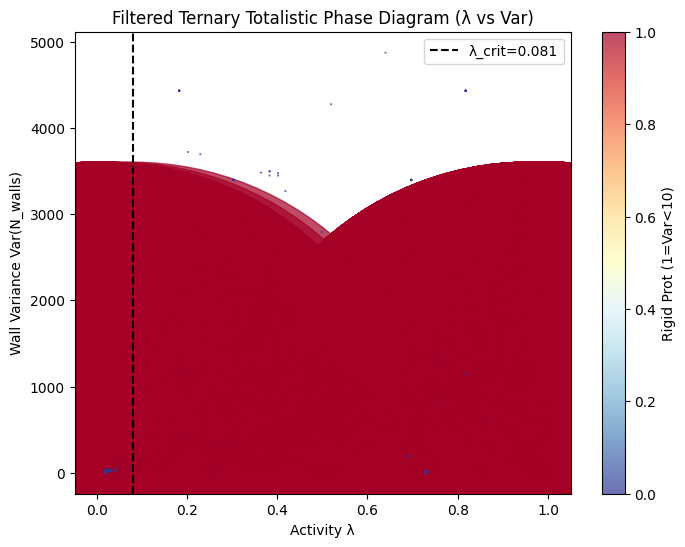

In [ ]:
prot = (vars_filt < 10).astype(int)
sizes = 1 / np.sqrt(vars_filt + 1e-8)
fig, ax = plt.subplots(figsize=(8,6))
scatter = ax.scatter(lambdas_filt, vars_filt, c=prot, cmap='RdYlBu_r', s=sizes*20, alpha=0.7)
ax.axvline(crit_lambda, color='k', ls='--', label=f'λ_crit={crit_lambda:.3f}')
ax.set_xlabel('Activity λ')
ax.set_ylabel('Wall Variance Var(N_walls)')
ax.set_title('Filtered Ternary Totalistic Phase Diagram (λ vs Var)')
plt.colorbar(scatter, label='Rigid Prot (1=Var<10)')
plt.legend()
plt.savefig('ternary_filtered_var.png')
plt.show()